In [1]:
import numpy as np
import networkx as nx
from random import randint
from random import shuffle
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from scipy.sparse.linalg import eigs
from scipy.sparse import diags, eye

from sklearn.linear_model import LogisticRegression
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import accuracy_score


# DeepWalk

In [1]:

############## Task 1
# Simulates a random walk of length "walk_length" starting from node "node"
def random_walk(G, node, walk_length):
    neighbors = list(G.neighbors(node))
    walk = [node]
    for i in range(walk_length-1):
        walk.append(neighbors[randint(0, len(neighbors)-1)])
        neighbors = list(G.neighbors(walk[-1]))
    walk = [str(node) for node in walk]
    return walk


############## Task 2
# Runs "num_walks" random walks from each node
def generate_walks(G, num_walks, walk_length):
    walks = []
    
    for node in G.nodes():
        for i in range(num_walks):
            walks.append(random_walk(G, node, walk_length))
    
    permuted_walks = np.random.permutation(walks)

    return permuted_walks.tolist()


# Simulates walks and uses the Skipgram model to learn node representations
def deepwalk(G, num_walks, walk_length, n_dim):
    print("Generating walks")
    walks = generate_walks(G, num_walks, walk_length)
    print("Training word2vec")
    model = Word2Vec(vector_size=n_dim, window=8, min_count=0, sg=1, workers=8, hs=1)
    model.build_vocab(walks)
    model.train(walks, total_examples=model.corpus_count, epochs=5)
    return model


# Visualization

Number of nodes: 33226
Number of edges: 354529
Generating walks
Training word2vec


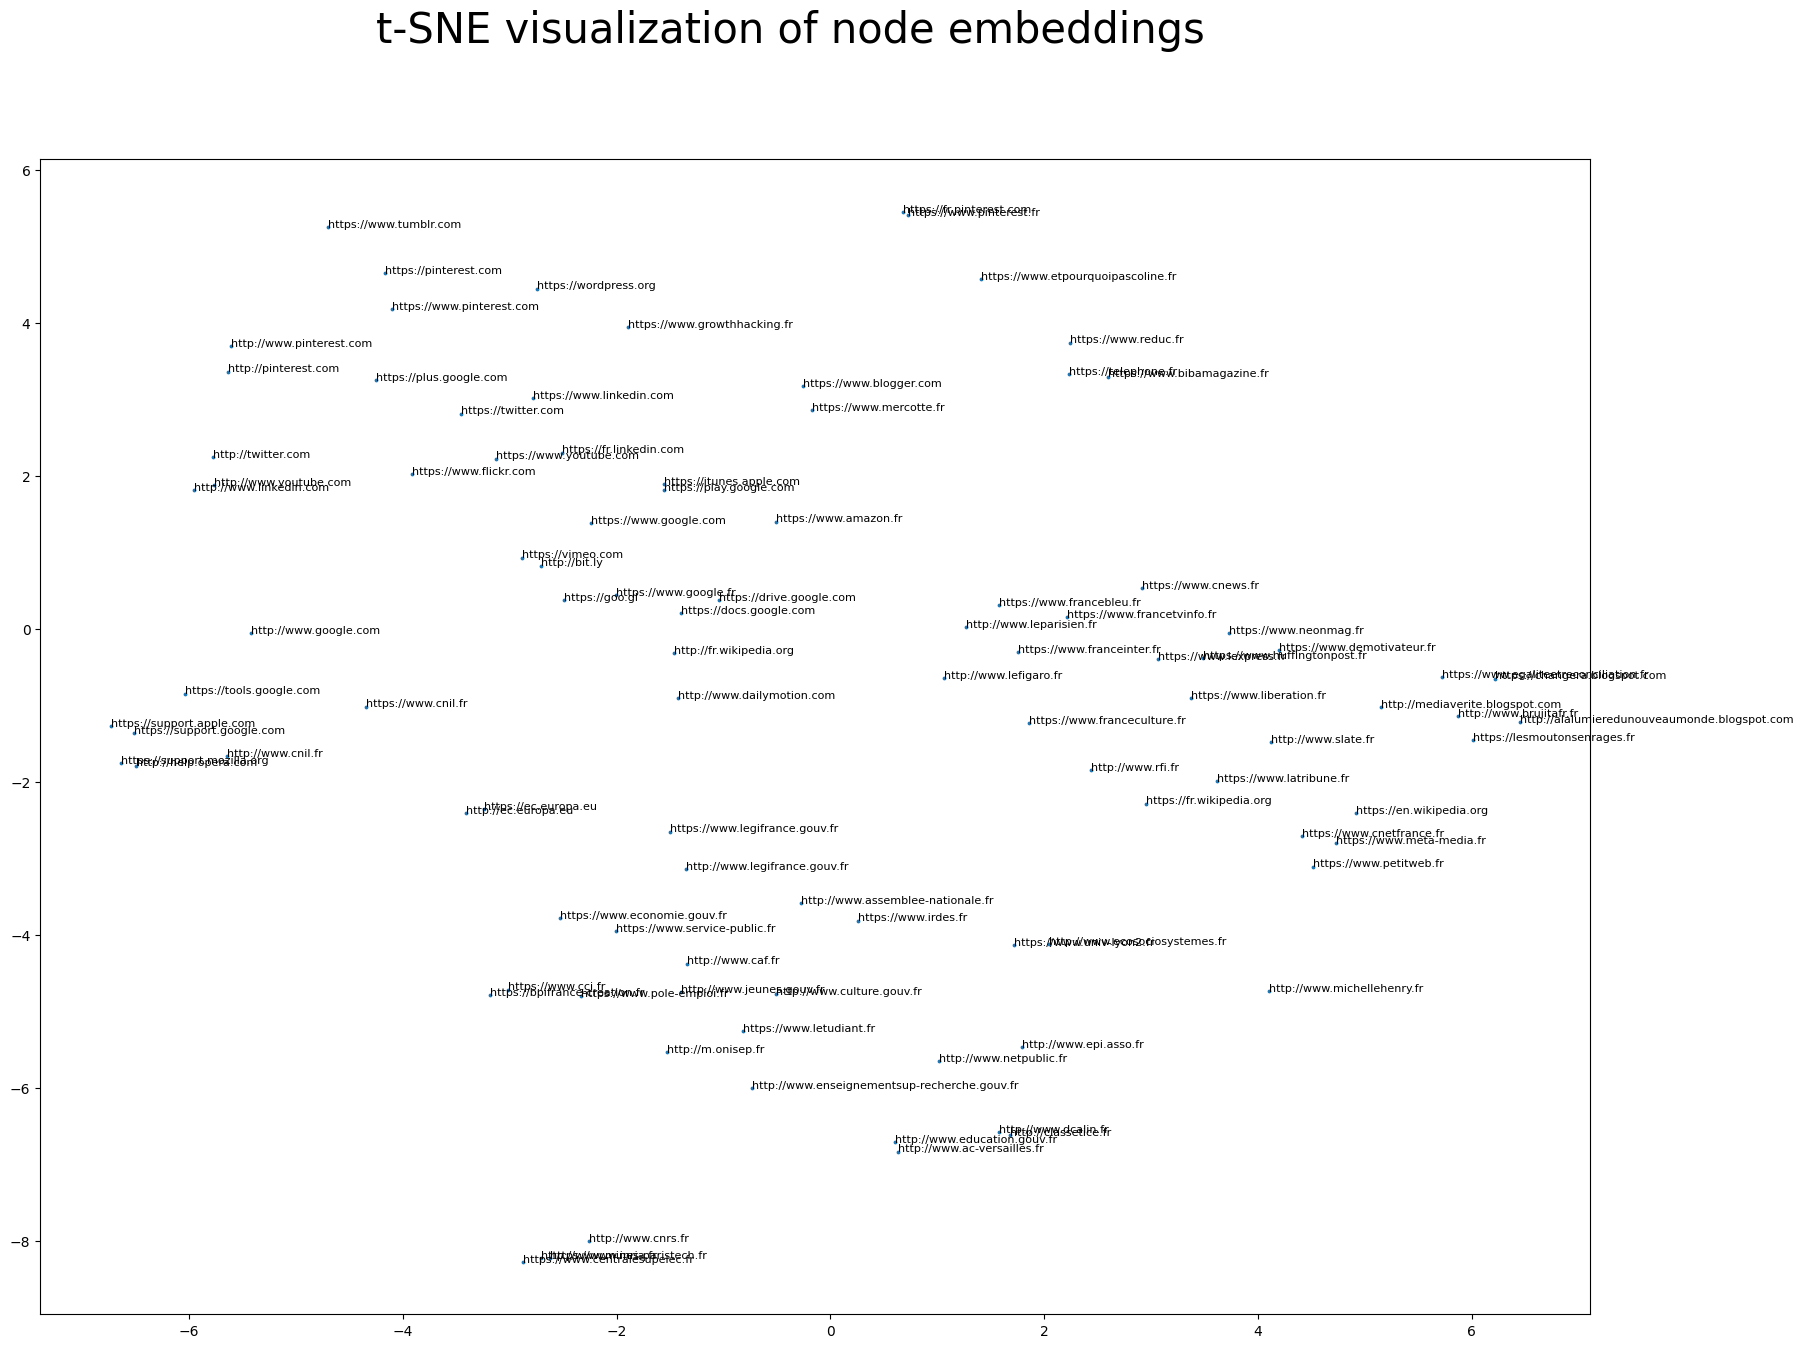

In [2]:


# Loads the web graph
G = nx.read_weighted_edgelist('/Users/halvardbariller/Desktop/M2 MVA/_SEMESTER 1/ALTEGRAD/TP/TP5 - DL for Graphs/ALTEGRAD_lab_5_DLForGraphs_2023/code/data/web_sample.edgelist', delimiter=' ', create_using=nx.Graph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


############## Task 3
# Extracts a set of random walks from the web graph and feeds them to the Skipgram model
n_dim = 128
n_walks = 10
walk_length = 20

model = deepwalk(G, n_walks, walk_length, n_dim)

############## Task 4
# Visualizes the representations of the 100 nodes that appear most frequently in the generated walks
def visualize(model, n, dim):

    nodes = model.wv.index_to_key[:n]

    DeepWalk_embeddings = np.empty(shape=(n, dim))

    for idx, node in enumerate(nodes):
        DeepWalk_embeddings[idx, :] = model.wv[node]



    my_pca = PCA(n_components=10)
    my_tsne = TSNE(n_components=2)

    vecs_pca = my_pca.fit_transform(DeepWalk_embeddings)
    vecs_tsne = my_tsne.fit_transform(vecs_pca)

    fig, ax = plt.subplots()
    ax.scatter(vecs_tsne[:,0], vecs_tsne[:,1],s=3)
    for x, y, node in zip(vecs_tsne[:,0] , vecs_tsne[:,1], nodes):     
        ax.annotate(node, xy=(x, y), size=8)
    fig.suptitle('t-SNE visualization of node embeddings',fontsize=30)
    fig.set_size_inches(20,15)
    plt.savefig('embeddings.pdf')  
    plt.show()


visualize(model, 100, n_dim)


# Node Classification

Number of nodes: 34
Number of edges: 78


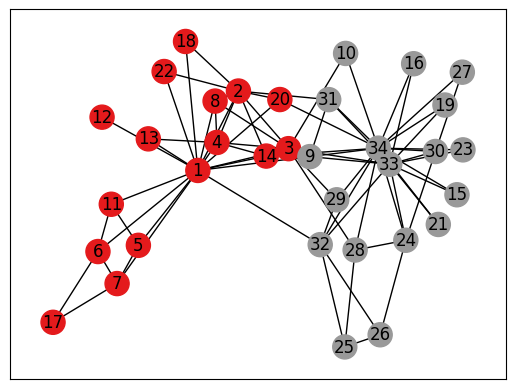

In [23]:


# Loads the karate network
edges_path = '/Users/halvardbariller/Desktop/M2 MVA/_SEMESTER 1/ALTEGRAD/TP/TP5 - DL for Graphs/ALTEGRAD_lab_5_DLForGraphs_2023/code/data/karate.edgelist'
G = nx.read_weighted_edgelist(edges_path, delimiter=' ', nodetype=int, create_using=nx.Graph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
labels_path = '/Users/halvardbariller/Desktop/M2 MVA/_SEMESTER 1/ALTEGRAD/TP/TP5 - DL for Graphs/ALTEGRAD_lab_5_DLForGraphs_2023/code/data/karate_labels.txt'
class_labels = np.loadtxt(labels_path, delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)


############## Task 5
# Visualizes the karate network

nx.draw_networkx(G, node_color=y, cmap=plt.cm.Set1, node_size=300, edge_color='black')

## Classifiers

In [76]:
idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

y_train = y[idx_train]
y_test = y[idx_test]

### DeepWalk Embedding

In [83]:
############## Task 6
# Extracts a set of random walks from the karate network and feeds them to the Skipgram model
n_dim = 128
n_walks = 10
walk_length = 20
model = deepwalk(G, n_walks, walk_length, n_dim)

embeddings = np.zeros((n, n_dim))
for i, node in enumerate(G.nodes()):
    embeddings[i,:] = model.wv[str(node)]

X_train_dw = embeddings[idx_train,:]
X_test_dw = embeddings[idx_test,:]

Generating walks
Training word2vec


In [84]:
############## Task 7
# Trains a logistic regression classifier and use it to make predictions

clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train_dw, y_train)
y_pred_dw = clf.predict(X_test_dw)
print("Accuracy:", accuracy_score(y_test, y_pred_dw))



Accuracy: 1.0


### Spectral Embedding

In [85]:
############## Task 8
# Generates spectral embeddings

def spectral_embedding(G, k):
    
    # Degree matrix
    degree_sequence = [G.degree(node) for node in G.nodes()]
    D_inv = diags([1/d for d in degree_sequence])
    # Adjacency matrix
    A = nx.adjacency_matrix(G)
    # Laplacian matrix
    L = eye(len(degree_sequence)) - D_inv @ A

    # Compute k smallest eigenvectors of L
    eigs_values, eigs_vectors = eigs(L, k=k, which='SR')
    U = np.real(eigs_vectors)

    return U

U = spectral_embedding(G, 2)

X_train_spec = U[idx_train,:]
X_test_spec = U[idx_test,:]

In [88]:
############## Task 7
# Trains a logistic regression classifier and use it to make predictions

clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train_spec, y_train)
y_pred_spec = clf.predict(X_test_spec)
print("Accuracy:", accuracy_score(y_test, y_pred_spec))


Accuracy: 0.8571428571428571


### Summary

In [87]:
print("The accuracy using DeepWalk is:", accuracy_score(y_test, y_pred_dw))
print("The accuracy using spectral embeddings is:", accuracy_score(y_test, y_pred_spec))


The accuracy using DeepWalk is: 1.0
The accuracy using spectral embeddings is: 0.8571428571428571
